In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')

In [2]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

In [4]:
data['pnns_groups_1'].value_counts()

unknown                    122881
Sugary snacks               30005
Milk and dairy products     17948
Composite foods             14670
Cereals and potatoes        14587
Fish Meat Eggs              13993
Beverages                   12411
Fat and sauces              11427
Fruits and vegetables       11095
Salty snacks                 5595
fruits-and-vegetables        1537
sugary-snacks                1451
cereals-and-potatoes           25
salty-snacks                    3
Name: pnns_groups_1, dtype: int64

A simple map allows for better organisation and also cleans the duplicate field entries:

In [5]:
my_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Fish Meat Eggs Dairy',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs Dairy',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['pnns_groups_1'].replace(my_map, inplace=True)

Now the categories are clear:

In [6]:
data['pnns_groups_1'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     31941
Composite                14670
Starchy                  14612
Fruits Vegetables        12632
Beverages                12411
Fat Sauces               11427
Name: pnns_groups_1, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [7]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [8]:
my_map_2 = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Fish Meat Eggs Dairy',
    'Meats' : 'Fish Meat Eggs Dairy',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs Dairy'
}

In [9]:
not_in_pnns = data[data['pnns_groups_1'].isna()]
keys = my_map_2.keys()
not_in_pnns.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [10]:
# First add the values from 'pnns_groups_1'
data['Category'] = data['pnns_groups_1']
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_pnns.query('main_category_en in @keys')['main_category_en'].replace(my_map_2)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [11]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     32021
Beverages                18255
Composite                14686
Starchy                  14612
Fruits Vegetables        12632
Fat Sauces               11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [12]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [13]:
data['Veggie'] = np.logical_or(data['Veggie'], data['Category'] == 'Fruits Vegetables')
data['Veggie'] = np.logical_or(data['Veggie'], data['Category'] == 'Starchy')

In [14]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [15]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
energy_bins = [data['energy_100g'].min(), 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

fat_bins = [data['fat_100g'].min(), 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

sugar_bins = [data['sugars_100g'].min(), 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

sodium_bins = [data['sodium_100g'].min(), 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

In [17]:
fvn_bins = [data['fruits-vegetables-nuts_100g'].min(), 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)
data['fvn_points'].fillna(0, inplace=True)

fiber_bins = [data['fiber_100g'].min(), 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

proteins_bins = [data['proteins_100g'].min(), 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)

data['points_C'] = data['fvn_points'] + data['fiber_points'] + data['proteins_points']

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['score'] = data.apply(compute_score, axis=1)

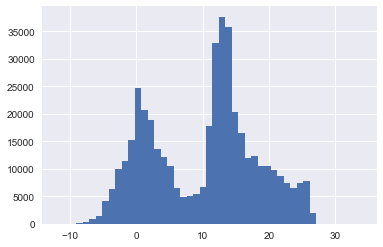

In [20]:
data['score'].hist(bins=int(data['score'].max() - data['score'].min() + 1))

In [21]:
score_mean_by_category = data[['Category', 'score']].groupby('Category').mean()
score_mean_by_category

,score
Category,
Beverages,4.976873
Composite,4.957496
Fat Sauces,11.620552
Fish Meat Eggs Dairy,8.106382
Fruits Vegetables,1.716984
Snacks,18.073932
Starchy,3.300240
Unknown,9.388888


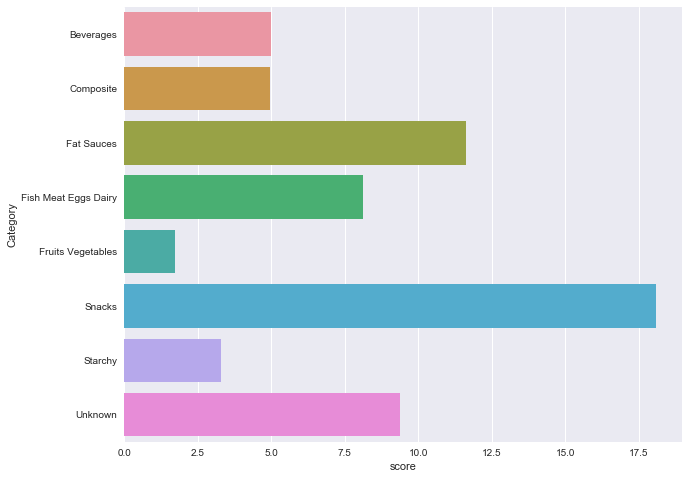

In [22]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category.score, score_mean_by_category.index,orient='h')

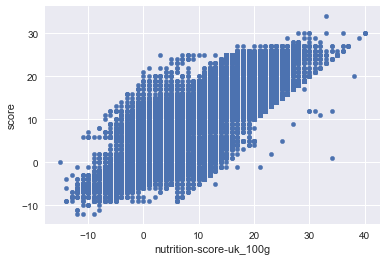

In [23]:
data.plot.scatter('nutrition-score-uk_100g', 'score')